In [2]:
from DMS_to_3D import *
sns.set_style('whitegrid')
%matplotlib inline

# Files and folders

In [13]:
CB95 = '../../../../Analysis/submission/additional_data/cbeta_dists/cbeta_dists_95th_percentile.csv'
CB975 = '../../../../Analysis/submission/additional_data/cbeta_dists/cbeta_dists_97.5-95th_percentile.csv'

GB1_full_epi = '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/constraints/gb1_topL_longrange_epi_constraints.csv'
WW_epi = '../../../../Analysis/submission/additional_data/ww_folding/constraints/ww_topL_longrange_epi_constraints.csv'

GB1_bstrands = '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/constraints/gb1_all_possible_strand_to_strand_pairs.csv'
WW_bstrands = '../../../../Analysis/submission/additional_data/ww_folding/constraints/ww_all_possible_strand_strand_pairs.csv'
GB1_sheet1 = '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/constraints/gb1_beta_pairs_psipred1.csv'
GB1_sheet2 = '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/constraints/gb1_beta_pairs_psipred2.csv'
GB1_sheet3 = '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/constraints/gb1_beta_pairs_psipred3.csv'
WW_sheet = '../../../../Analysis/submission/additional_data/ww_folding/constraints/ww_beta_pairs.csv'

# Overview

Our protein folding protocol generates models by minimizing residue-residue distance constraints, specified according to the epistasis data. Many models are generated, and we want to blindly identify the model most likely to be a precise estimate of the true 3D structure. Therefore, we score each model according to how well it agrees with the structural constraints:
- bond angles VS predicted secondary structure
    according to the method in *Marks PLoS One (2011)*, scoring how well the backbone bond angles of residues in alpha helices and in beta strands fall within experimentally observed ranges.
- 3D distances versus predicted residue-residue contacts according to the method in *Ovchinnikov eLife (2015)* and *Kamisetty PNAS (2013)*, which evalutes the proximity of residue-residue pairs
$$ \sum_n w_n * sigmoid( dist_{ij,n}, \eta_n, \kappa_n ) $$
Residue-residue contacts are scored by the distance of the corresponding C-beta atoms, using a sigmoid function. Essentially: 'contacting' (closer than $\eta$) pairs score 1, whereas more distant pairs scores exponentially decay to 0 with distance (at a rate $\propto 1/\kappa^2$).
These values are weighted by the 'strength' of the predicted pair (in our case, positive epistasis) and summed.





**Note-** some background to folding methodology. While we have pairwise structural information and therefore require less sampling than uninformed model generation, to find a 3D fold it is necessary to sample many possible structures, because:
- the minimization is not guaranteed to reach a global minimum
- there are multiple ways to satisfy any set of constraints
- it is unknown what the ideal constraints are for minimizing to a precise fold\*

\* This is why we fold with a range of numbers of constraints from the top epistasis pairs. Using a single number of constraints might arbitrarily include several false positives, or over-represent some residue for the purposes of folding.

# Functions

## Calculate weights and fetch c-beta distances

Load C-beta matrices

In [14]:
cb95 = sym_mat(CB95)
cb975 = sym_mat(CB975)

## Scoring equations

In [15]:
def sigmoid(d, nu, ka):
    '''sigmoid activator function'''
    if d < nu:
        f = 1
    else:
        f = np.exp(-((d - nu)**2) / (2*(ka**2)))
    return(f)

In [16]:
def pair_score(dists, pairs):
    '''computes weighted sigmoid score across pairs'''
    pairs.loc[:, 'dist'] = dists[:len(pairs)]
    s = pairs.apply(lambda x: sigmoid(x['dist'], x['nu'], x['ka']), axis=1)
    return(np.sum(pairs['weight'] * s))

## Computing scores from pairwise distances, and constraint table

Gets called in the function 'compare_tbl'- which also does the work of loading in and merging the appropriate files.

In [17]:
def constraint_scores(dists, PAIRS, L, cb95, cb975, STRAND, SHEET):
    '''computes secondary structure, 3D pair, and sheet scores'''
    if isinstance(dists, str):
        dists = pd.read_csv(dists, sep=';')
        dists = read_dists(dists)

    dists = dists.rename(columns={'ranking_score': 'ss_score'})
    pairs = weights_table(PAIRS, L, cb95, cb975)
    sheet = load_backbone_constraints(STRAND, SHEET)
    N = np.sum(sheet['weight'])

    dists.loc[:, 'pair_score'] = dists['cb_dists'].apply(
        lambda x: pair_score(x, pairs))/L
    dists.loc[:, 'sheet_score'] = dists['bb_dists'].apply(
        lambda x: pair_score(x, sheet))/N

    # each term in score is normalized
    # to be between 0 and 1 (maximum possible), and added in 3 equal parts
    dists.loc[:, 'score'] = \
        (dists['ss_score'] + dists['pair_score'] + dists['sheet_score'])/3

    return(dists)

# Ranking the models

## Join GB1 tables and score

### Full GB1 results

In [18]:
gb1_scores1 = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/rmsd/dgsa_1b-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/ranking/dgsa_1b-all_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_sheet1)

gb1_scores2 = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/rmsd/dgsa_2b-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/ranking/dgsa_2b-all_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_sheet2)

gb1_scores3 = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/rmsd/dgsa_3b-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_full/ranking/dgsa_3b-all_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_sheet3)

### GB1 results without predicted sheet constraints

In [20]:
gb1_scores1_noB = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/rmsd/dgsa_1-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/ranking/dgsa_1_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_bstrands)

gb1_scores2_noB = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/rmsd/dgsa_2-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/ranking/dgsa_2_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_bstrands)

gb1_scores3_noB = compare_tbl(
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/rmsd/dgsa_3-rmsds.txt',
    '../../../../Analysis/submission/additional_data/gb1_folding/gb1_no_beta_constraints/ranking/dgsa_3_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_bstrands)

### WW results

In [79]:
ww_scores= compare_tbl(
    '../../../../Analysis/submission/additional_data/ww_folding/rmsd/ww_dgsa-rmsds.txt',
    '../../../../Analysis/submission/additional_data/ww_folding/ranking/ww_dgsa-all_scores.csv',
    WW_epi, 37, cb95, cb975, WW_bstrands, WW_sheet)

### GB1 reference - 2gb1 experimental structure

In [269]:
gb1_ref = constraint_scores('../additional_data/gb1_folding/control/GB1_2gb1_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_sheet3)

In [243]:
gb1_ref['score']

0    0.679019
Name: comb_score, dtype: float64

No betas reference

In [270]:
gb1_ref_noB = constraint_scores('../additional_data/gb1_folding/control/GB1_2gb1_scores.csv',
    GB1_full_epi, 56, cb95, cb975, GB1_bstrands, GB1_bstrands)

In [271]:
gb1_ref_noB['score']

0    0.503378
Name: comb_score, dtype: float64

### WW reference - 1jmq experimental structure

In [81]:
ww_ref = constraint_scores('../../../../Analysis/submission/additional_data/ww_folding/control/WW_1jmq_scores.csv',
    WW_epi, 37, cb95, cb975, WW_bstrands, WW_sheet)

In [273]:
ww_ref['score']

0    0.678086
Name: comb_score, dtype: float64

# Plot to demonstrate rank correlation

**Note:** the reference point has shifted values in order to have axes jumps, the axes labels are modified such that the value is still plotted precisely

### GB1 full dgsa

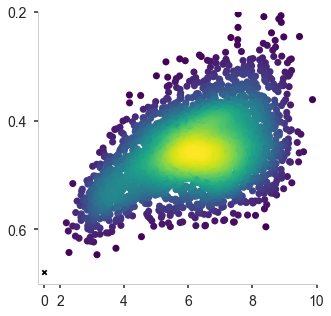

In [67]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = pd.concat([gb1_scores1, gb1_scores2, gb1_scores3]).reset_index()
scatter_density(z['rmsd'], z['score'], ax)
ax.scatter([1.5], [0.679019],  color='black', marker='x', s=20)

set_axis(ax, [1.5, 2, 4, 6, 8, 10], [0, 0.2, 0.4, 0.6, 0.8, 1],
         (1.3, 10), (0.2, 0.7),  xls = [0, 2, 4, 6, 8, 10])

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticklabels(['', 0.2, 0.4, 0.6], fontsize=14)
ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.tick_params(direction='out', length=4, width=1.5, axis='x')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#!mkdir ../supplementary_figures/model_ranking
fig.savefig('../../final_formatted_submission/raw_components/supfig8-gb1_full_dgsa-ranking-nogrid.svg')

#!mkdir ../supplementary_tables/model_ranking
#z.sort_values('score', ascending=False).to_csv('../supplementary_tables/model_ranking/gb1_rank-vs-rmsd3.csv', index=False)

AttributeError: 'AxesSubplot' object has no attribute 'set_xtick_labels'

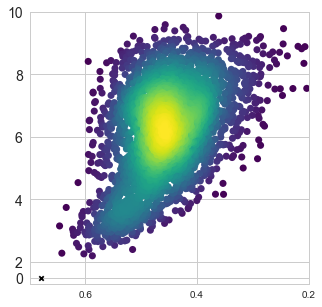

In [53]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = pd.concat([gb1_scores1, gb1_scores2, gb1_scores3]).reset_index()
scatter_density(z['score'], z['rmsd'], ax)
ax.scatter([0.679019], [1.5], color='black', marker='x', s=20)

set_axis(ax, [0, 0.2, 0.4, 0.6, 0.8, 1], [1.5, 2, 4, 6, 8, 10],
         (0.2, 0.7), (1.3, 10), yls = [0, 2, 4, 6, 8, 10])


ax.set_xticklabels([, fontsize=10)
ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.tick_params(direction='out', length=4, width=1.5, axis='x')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#!mkdir ../supplementary_figures/model_ranking
#fig.savefig('../supplementary_figures/model_ranking/gb1_full_dgsa-ranking2.svg')

#!mkdir ../supplementary_tables/model_ranking
#z.sort_values('score', ascending=False).to_csv('../supplementary_tables/model_ranking/gb1_rank-vs-rmsd3.csv', index=False)

### GB1 without beta constraints

In [74]:
?scatter_density

Signature: scatter_density(x, y, ax)
Docstring: creates scatter plot, coloring dots by density in area
File:      ~/Dropbox (HMS)/DMS_folding/Manuscript/NatureGenetics_V2/ExtendedData/notebooks/DMS_to_3D.py
Type:      function


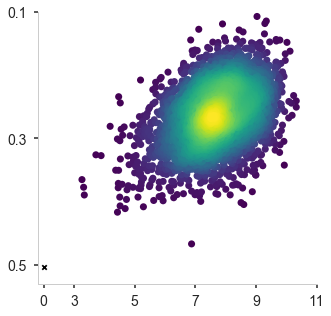

In [76]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = pd.concat([gb1_scores1_noB, gb1_scores2_noB, gb1_scores3_noB]).reset_index()
scatter_density( z['rmsd'], z['score'], ax)
ax.scatter([2], [0.503378],color='black', marker='x', s=20)

set_axis(ax,  [2, 3, 5, 7, 9, 11], [0.1, 0.3, 0.5],
          (1.8, 11), (0.1, 0.53), xls = [0, 3, 5, 7, 9, 11])

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticklabels([0.1, 0.3, 0.5], fontsize=14)
ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.tick_params(direction='out', length=4, width=1.5, axis='x')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#!mkdir ../supplementary_figures/model_ranking
fig.savefig('../../final_formatted_submission/raw_components/supfig8-gb1_nobeta-ranking-nogrid.svg')

mkdir: ../supplementary_figures/model_ranking: File exists
mkdir: ../supplementary_tables/model_ranking: File exists


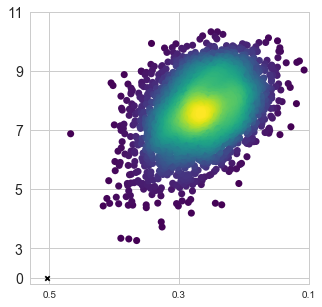

In [35]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = pd.concat([gb1_scores1_noB, gb1_scores2_noB, gb1_scores3_noB]).reset_index()
scatter_density(z['score'], z['rmsd'], ax)
ax.scatter([0.503378], [2], color='black', marker='x', s=20)

set_axis(ax, [0.1, 0.3, 0.5], [2, 3, 5, 7, 9, 11],
         (0.1, 0.53), (1.8, 11), yls = [0, 3, 5, 7, 9, 11])

!mkdir ../supplementary_figures/model_ranking
fig.savefig('../supplementary_figures/model_ranking/gb1_noBeta_dgsa-ranking.svg')

!mkdir ../supplementary_tables/model_ranking
z.sort_values('score', ascending=False).to_csv('../supplementary_tables/model_ranking/gb1_noBeta_rank-vs-rmsd.csv', index=False)

### WW dgsa

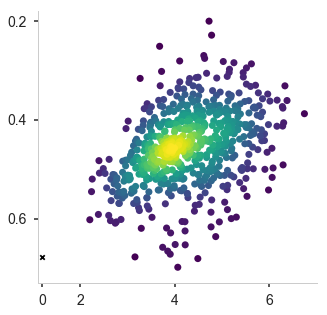

In [84]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = ww_scores
scatter_density(z['rmsd'], z['score'], ax)
ax.scatter([1.2], [0.678086], color='black', marker='x', s=20)

set_axis(ax, [1.2, 2, 4, 6],[0.2, 0.4, 0.6], 
         (1.1, 7),(0.18, 0.73),  xls = [0, 2, 4, 6])

ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticklabels([0.2, 0.4, 0.6], fontsize=14)
ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.tick_params(direction='out', length=4, width=1.5, axis='x')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig('../../final_formatted_submission/raw_components/supfig8-ww-ranking-nogrid.svg')

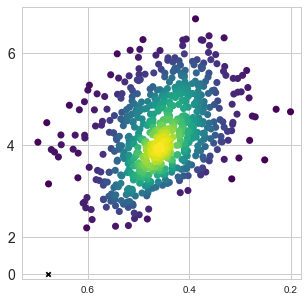

In [82]:
fig, ax = plt.subplots(1)
fig.set_size_inches(5, 5)
z = ww_scores
scatter_density(z['score'], z['rmsd'], ax)
ax.scatter([0.678086], [1.2], color='black', marker='x', s=20)

set_axis(ax, [0.2, 0.4, 0.6], [1.2, 2, 4, 6],
         (0.18, 0.73), (1.1, 7), yls = [0, 2, 4, 6])
#
#!mkdir ../supplementary_figures/model_ranking
#fig.savefig('../supplementary_figures/model_ranking/ww_dgsa-ranking.svg')
#
#!mkdir ../supplementary_tables/model_ranking
#z.sort_values('score', ascending=False).to_csv('../supplementary_tables/model_ranking/ww_rank-vs-rmsd.csv', index=False)

# Subsampling results

### merging tables and computing ranking scores (note: it's a lot of samples, will take ~ 1 hr, so just load these from pre-computedtables)

In [8]:
def get_size_and_sample(samples):
    '''extracts library size and sample # from filename'''
    samples = pd.read_csv(samples)
    samples.loc[:, 'size'] = samples['pdb_name'].apply(lambda x: x.split('_')[1].split('p')[0].split('-')[0])
    samples.loc[:, 'N'] = samples['pdb_name'].apply(lambda x: int(x.split('-')[-1].split('_')[0]))
    return(samples)

In [10]:
any_pair = get_size_and_sample('../../../../Analysis/submission/additional_data/gb1_subsampling/ranking/any_pair-subsampling-scores.csv')
del_pair = get_size_and_sample('../../../../Analysis/submission/additional_data/gb1_subsampling/ranking/del_pair-subsampling-scores.csv')
one_del = get_size_and_sample('../../../../Analysis/submission/additional_data/gb1_subsampling/ranking/one_del-subsampling-scores.csv')

## Folding plots, subsampling

In [22]:
gb1_all.keys()

Index(['index', 'bb_dists', 'cb_dists', 'filename_x', 'na_dists', 'sc_dists',
       'num_alpha_dihedrals', 'alpha_dihedral_score', 'num_beta_dihedrals',
       'beta_dihedral_score', 'ss_score', 'pdb_name', 'filename_y', 'rmsd',
       'pair_score', 'sheet_score', 'score'],
      dtype='object')

In [33]:
?ax.tick_params

Signature: ax.tick_params(axis='both', **kwargs)
Docstring:
Change the appearance of ticks and tick labels.

Parameters
----------
axis : {'x', 'y', 'both'}, optional
    Which axis to apply the parameters to.

Other Parameters
----------------

axis : {'x', 'y', 'both'}
    Axis on which to operate; default is 'both'.

reset : bool
    If *True*, set all parameters to defaults
    before processing other keyword arguments.  Default is
    *False*.

which : {'major', 'minor', 'both'}
    Default is 'major'; apply arguments to *which* ticks.

direction : {'in', 'out', 'inout'}
    Puts ticks inside the axes, outside the axes, or both.

length : float
    Tick length in points.

width : float
    Tick width in points.

color : color
    Tick color; accepts any mpl color spec.

pad : float
    Distance in points between tick and label.

labelsize : float or str
    Tick label font size in points or as a string (e.g., 'large').

labelcolor : color
    Tick label color; mpl color spec.

col

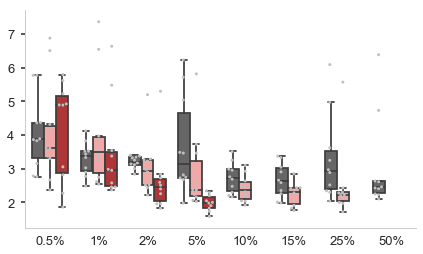

In [38]:
fig, ax = plt.subplots(1)

z = any_pair.sort_values('score', ascending=False).groupby(['size', 'N'])['rmsd'].apply(lambda x: np.min(x))
a = pd.DataFrame({
    'size': z.reset_index()['size'].astype(float)/100,
    'rmsd': z.reset_index()['rmsd'].astype(float)
}).assign(strategy=1)

z = del_pair.sort_values('score', ascending=False).groupby(['size', 'N'])['rmsd'].apply(lambda x: np.min(x))
b = pd.DataFrame({
    'size': z.reset_index()['size'].apply(lambda x: 6.5 if (x == 'full') else float(x))/100,
    'rmsd': z.reset_index()['rmsd'].astype(float)
}).assign(strategy=3)


z = one_del.sort_values('score', ascending=False).groupby(['size', 'N'])['rmsd'].apply(lambda x: np.min(x))
c = pd.DataFrame({
    'size': z.reset_index()['size'].apply(lambda x: 0.4 if (x == 'full') else float(x)),
    'rmsd': z.reset_index()['rmsd'].astype(float)
}).assign(strategy=2)

gb1_all = pd.concat([gb1_scores1, gb1_scores2, gb1_scores3]).reset_index()
d = gb1_all.sort_values('score').iloc[-10:].assign(strategy=1, size=1)
d = pd.DataFrame([dict(d.sort_values('rmsd').iloc[0])])

cdf = pd.concat([a, b[~b['size'].eq(0.065)], c])
#'#ff9999'
my_pal1 = {1: '#666666', 2: '#fc9c9c', 3: '#c32222'}
C = 'silver'
my_pal2 = {1: C, 2: C, 3: C}
sns.boxplot(x='size', y='rmsd', hue='strategy',
            data=cdf, ax=ax, color=['gray', 'red'],
            palette=my_pal1, width=0.75, fliersize=0)
sns.swarmplot(x='size', y='rmsd', hue='strategy',
              data=cdf, ax=ax, palette=my_pal2, s=3, split=True)

ax.legend([])

ax.set_yticks(
    [2, 3, 4, 5, 6, 7])
ax.set_yticklabels(
    [2, 3, 4, 5, 6, 7], fontsize=13)

ax.set_xticklabels(
    ['0.5%', '1%', '2%', '5%',
     '10%', '15%', '25%', '50%'], fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')

fig.set_size_inches(7, 4) 

ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig('../../final_formatted_submission/raw_components/fig5_A_nogridlines.svg')
#fig.savefig('../supplementary_figures/subsampling/subsampling_final_rmsds_n10.svg')

## Precision plots, subsampling

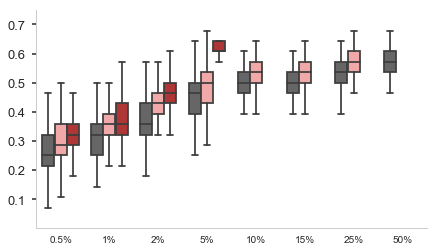

In [48]:
fig, ax = plt.subplots(1)

a = pd.read_csv('../../../../Analysis/submission/additional_data/gb1_subsampling/precision/any_pair-precision_n1000.csv').assign(strategy=1)
b = pd.read_csv('../../../../Analysis/submission/additional_data/gb1_subsampling/precision/one_del-precision_n1000.csv').assign(strategy=2)
c = pd.read_csv('../../../../Analysis/submission/additional_data/gb1_subsampling/precision/del_pair-precision_n1000.csv').assign(strategy=3)

cdf = pd.concat([a, b, c])
#'#ff9999'
my_pal1 = {1: '#666666', 2: '#fc9c9c', 3: '#c32222'}
C = 'silver'
my_pal2 = {1: C, 2: C, 3: C}
x = 'library size'
y = 'L/2 (i-j > 5)'
sns.boxplot(x=x, y=y, hue='strategy',
            data=cdf, ax=ax, color=['gray', 'red'],
            palette=my_pal1, width=0.75, fliersize=0)

ax.legend([])
ax.set_yticklabels(
    ['', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], fontsize=13)
ax.set_xticklabels(
    ['0.5%', '1%', '2%', '5%',
     '10%', '15%', '25%', '50%'])
ax.set_xlabel('')
ax.set_ylabel('')

fig.set_size_inches(7, 4) 
ax.tick_params(direction='out', length=4, width=1.5, axis='y')
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

fig.savefig('../../final_formatted_submission/raw_components/fig5_nogridlines.svg')

In [42]:
cdf.keys()

Index(['library size', 'L/2', 'L', 'L/2 (i-j > 5)', 'L (i-j > 5)', 'strategy'], dtype='object')